## 4.2 linear regression

In [1]:
import scipy
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt

# Make the simulation data
size_cluster = 300
mat_cov = scipy.eye(2)
cluster1 = scipy.random.multivariate_normal([-4, -4], mat_cov, size_cluster)
cluster2 = scipy.random.multivariate_normal([0, 0], mat_cov, size_cluster)
cluster3 = scipy.random.multivariate_normal([4, 4], mat_cov, size_cluster)
target1, target2, target3 = scipy.eye(3)
# print(target1, target2, target3, type(target1))
mat_x0 = scipy.concatenate((cluster1, cluster2, cluster3))
mat_x = scipy.hstack((scipy.ones((size_cluster*3, 1)), mat_x0))
mat_y = scipy.vstack((scipy.tile(target1, (size_cluster, 1)),
                      scipy.tile(target2, (size_cluster, 1)),
                      scipy.tile(target3, (size_cluster, 1))))

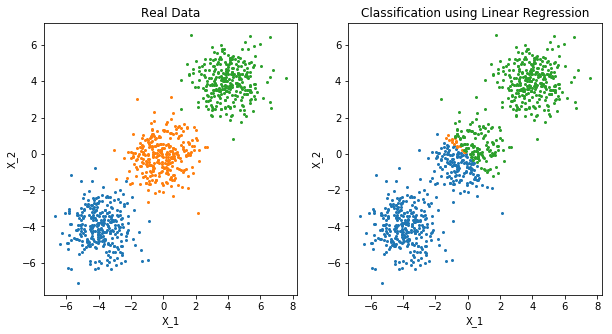

In [2]:
# Multiple linear regression
mat_beta = scipy.linalg.solve(mat_x.T @ mat_x, mat_x.T @ mat_y)
mat_y_hat = mat_x @ mat_beta
assert scipy.allclose(mat_y_hat.sum(axis=1), 1)
idx_classified_y = mat_y_hat.argmax(axis=1)

classified_cluster1 = mat_x0[idx_classified_y == 0]
classified_cluster2 = mat_x0[idx_classified_y == 1]
classified_cluster3 = mat_x0[idx_classified_y == 2]

fig42 = plt.figure(0, figsize=(10, 5))
ax1 = fig42.add_subplot(1, 2, 1)
ax1.plot(cluster1[:,0], cluster1[:,1], 'o', color='C0', markersize=2)
ax1.plot(cluster2[:,0], cluster2[:,1], 'o', color='C1', markersize=2)
ax1.plot(cluster3[:,0], cluster3[:,1], 'o', color='C2', markersize=2)
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')
ax1.set_title('Real Data')

ax2 = fig42.add_subplot(1, 2, 2)
ax2.plot(classified_cluster1[:,0], classified_cluster1[:,1], 'o', color='C0', markersize=2)
ax2.plot(classified_cluster2[:,0], classified_cluster2[:,1], 'o', color='C1', markersize=2)
ax2.plot(classified_cluster3[:,0], classified_cluster3[:,1], 'o', color='C2', markersize=2)
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')
ax2.set_title('Classification using Linear Regression')
plt.show()

## 4.3 LDA

In [3]:
# Estimating parameters
vec_mean1 = cluster1.mean(axis=0)
vec_mean2 = cluster2.mean(axis=0)
vec_mean3 = cluster3.mean(axis=0)

cluster_centered1 = cluster1 - vec_mean1
cluster_centered2 = cluster2 - vec_mean2
cluster_centered3 = cluster3 - vec_mean3
mat_cov = (cluster_centered1.T @ cluster_centered1 +
           cluster_centered2.T @ cluster_centered2 +
           cluster_centered3.T @ cluster_centered3)/(3*size_cluster-3)

# Calculate linear discriminant scores
sigma_inv_mu123 = scipy.linalg.solve(
    mat_cov,
    scipy.vstack((vec_mean1, vec_mean2, vec_mean3)).T,
)
sigma_inv_mu1, sigma_inv_mu2, sigma_inv_mu3 = sigma_inv_mu123.T

mat_x = scipy.vstack((cluster1, cluster2, cluster3))
mat_delta = (mat_x @ sigma_inv_mu123 -
             scipy.array((vec_mean1 @ sigma_inv_mu1,
                          vec_mean2 @ sigma_inv_mu2,
                          vec_mean3 @ sigma_inv_mu3))/2)

cluster_classified1 = mat_x[mat_delta.argmax(axis=1) == 0]
cluster_classified2 = mat_x[mat_delta.argmax(axis=1) == 1]
cluster_classified3 = mat_x[mat_delta.argmax(axis=1) == 2]

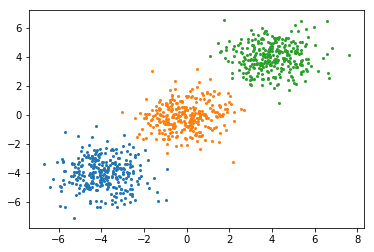

In [4]:
plt.plot(cluster_classified1[:,0], cluster_classified1[:,1], 'o', color='C0', markersize=2)
plt.plot(cluster_classified2[:,0], cluster_classified2[:,1], 'o', color='C1', markersize=2)
plt.plot(cluster_classified3[:,0], cluster_classified3[:,1], 'o', color='C2', markersize=2)

plt.show()

## 4.4 Logistic Regression
### 4.4.2 South African Heart Disease
Analyze data

In [5]:
import seaborn as sns

In [6]:
df_saheart = pd.read_csv('./data/heart/SAheart.data', index_col=0)
df_saheart['famhist'] = df_saheart['famhist'].map({'Present': 1,
                                                   'Absent': 0})
df_saheart.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [7]:
df_saheart.describe()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,0.415584,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,0.493357,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,0.000000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,0.000000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,0.000000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,1.000000,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,1.000000,78.000000,46.580000,147.190000,64.000000,1.000000


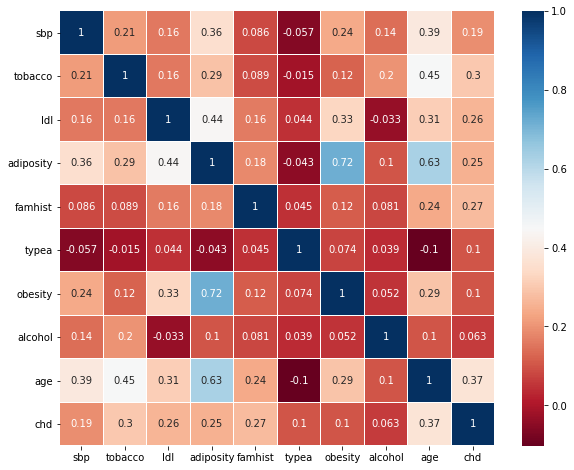

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(df_saheart.corr(), linewidths=0.1,vmax=1.0, 
            square=True, cmap="RdBu", linecolor='white', annot=True)

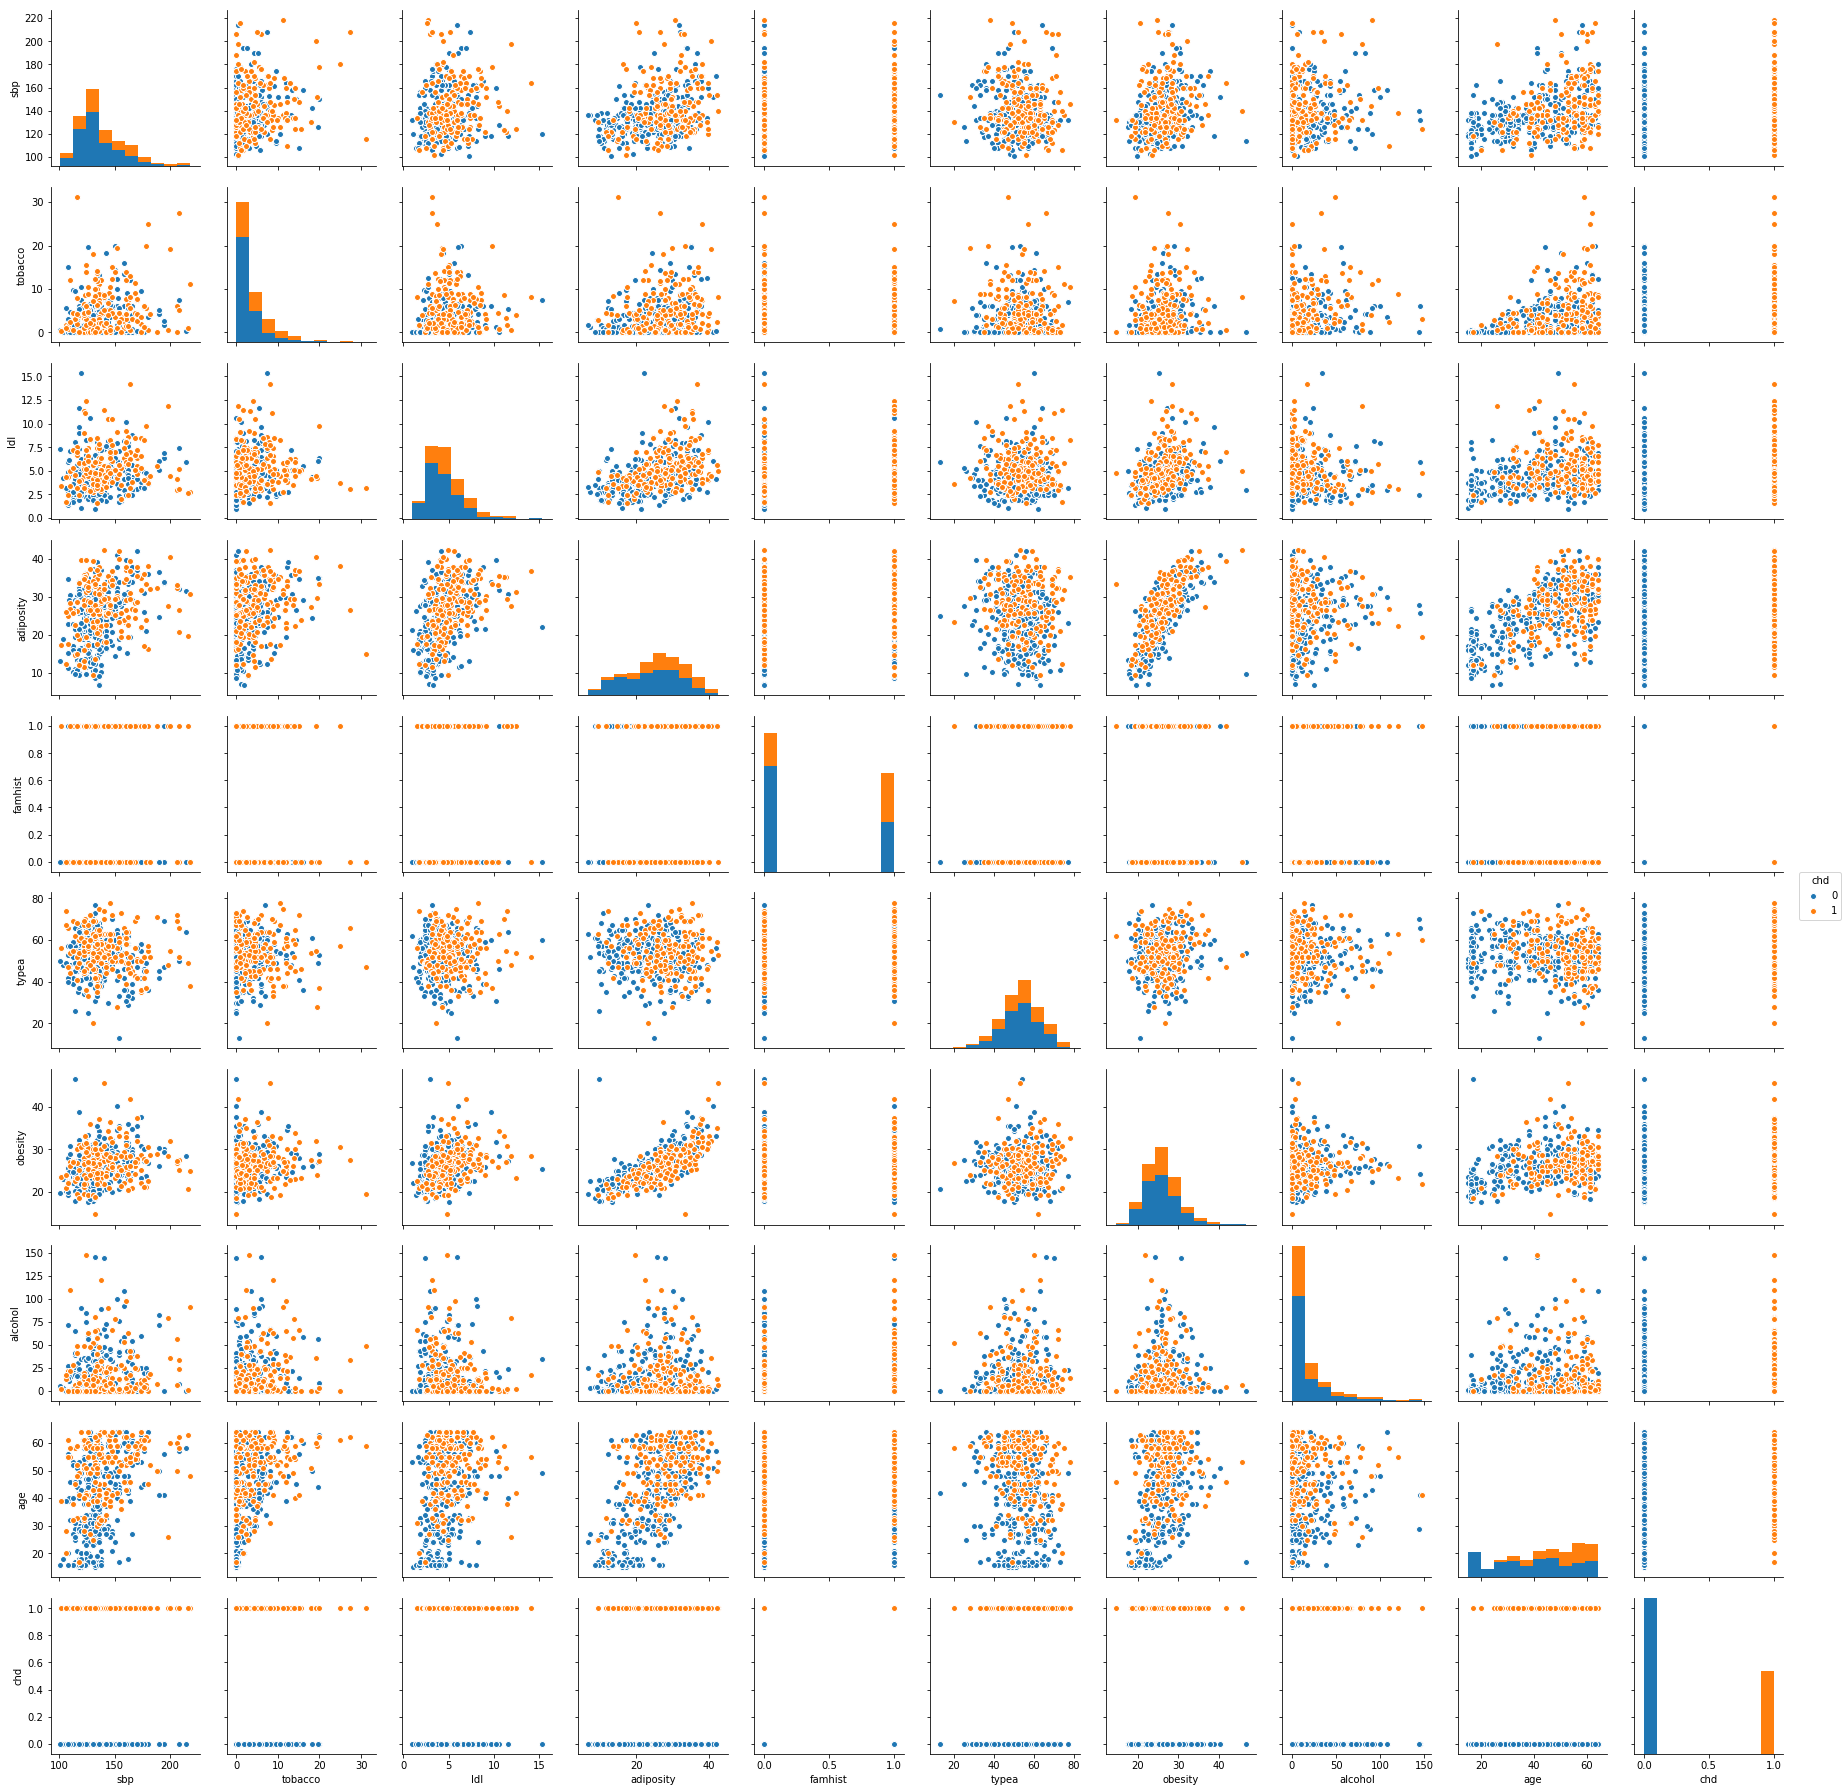

In [9]:
sns.pairplot(data=df_saheart, hue='chd')

model

In [10]:
X = df_saheart.drop(columns=['chd', 'adiposity', 'typea']) #text book doesn't use them
Y = df_saheart['chd']

In [11]:
mat_X = X.as_matrix()
size_training, size_predictor = mat_X.shape
size_beta = size_predictor + 1

vec_y = Y.as_matrix()
mat_1X = scipy.hstack((scipy.ones((size_training, 1)), mat_X))

def fvec_p(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    num = scipy.exp(mat_x@vec_beta)
    return num/(num+1)

def fdiag_W(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    vec_p = fvec_p(mat_x, vec_beta)
    return vec_p*(1-vec_p)

In [12]:
vec_beta_old = scipy.zeros(size_beta)
vec_increment = scipy.ones(size_beta)
while (vec_increment**2).sum() > 1e-8:
    vec_p = fvec_p(mat_1X, vec_beta_old)
    gradient = mat_1X.T @ (vec_y-vec_p)
    hessian = mat_1X.T @ scipy.diag(fdiag_W(mat_1X, vec_beta_old)) @ mat_1X
    vec_increment = scipy.linalg.solve(hessian, gradient)
    vec_beta_new = vec_beta_old + vec_increment
    vec_beta_old = vec_beta_new.copy()

In [13]:
print('{0:>15} {1:>15}'.format('Term', 'Coefficient'))
print('-'*32)
table_term = ['intercept'] + list(df_saheart.columns)
for term, coeff in zip(table_term, vec_beta_new):
    print('{0:>15} {1:>15f}'.format(term, coeff))

           Term     Coefficient
--------------------------------
      intercept       -4.129600
            sbp        0.005761
        tobacco        0.079526
            ldl        0.184779
      adiposity        0.939185
        famhist       -0.034543
          typea        0.000607
        obesity        0.042541


## LDA, QDA Logistic Regression Example with sklearn

In [14]:
vowel_df = pd.read_csv('./data/vowel/vowel.train', index_col=0)
X = vowel_df.drop(columns=['y'])
y = vowel_df['y']

In [15]:
def plot_scatter(x_data, y_label, title):
    num = 11
    plt.grid(True)
    plt.title(title)
    for i in range(11):
        plt.scatter(x_data[y_label == i+1, 0], x_data[y_label == i+1, 1], s=50, edgecolor='black', cmap='Set2')

In [22]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

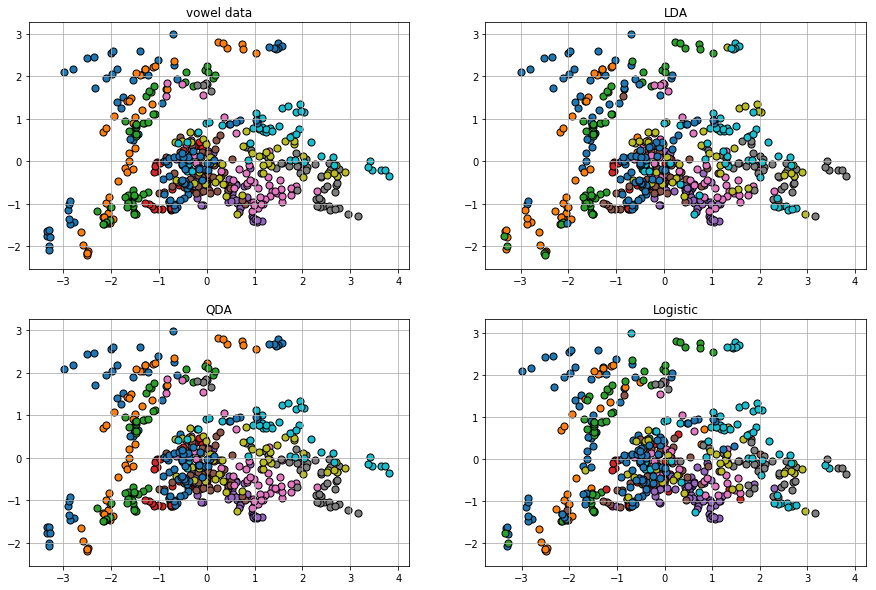

In [33]:
# PCA
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

fig51 = plt.figure(51, figsize=(15, 10))
ax1 = fig51.add_subplot(2, 2, 1)
plot_scatter(X_r, y, "vowel data")

# LinearDiscriminantAnalysis
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X, y)
y_pred_lda = lda_clf.predict(X)

ax2 = fig51.add_subplot(2, 2, 2)
plot_scatter(X_r, y_pred_lda, "LDA")

# QuadraticDiscriminantAnalysis
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X, y)
y_pred_qda = qda_clf.predict(X)

ax3 = fig51.add_subplot(2, 2, 3)
plot_scatter(X_r, y_pred_qda, "QDA")

# LogisticModel
logreg = LogisticRegression(C=1e8)
logreg.fit(X, y)
y_pred_logreg = logreg.predict(X)

ax4 = fig51.add_subplot(2, 2, 4)
plot_scatter(X_r, y_pred_logreg, "Logistic")

In [35]:
print(lda_clf.score(X, y), qda_clf.score(X, y), logreg.score(X, y))

0.683712121212 0.988636363636 0.660984848485


In [ ]:
logreg